# Preparing Input

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
driver = GoogleDrive(gauth)

In [ ]:
download = driver.CreateFile({'id': '1bXKJXQmQSka7UYq_M3ZpCMgxWa2WXord'}) # Santa Maria Yield
#download = driver.CreateFile({'id': '1TDfk4KjQAXEQAhHDbvtEyFK27JXwgTzX'}) # Oxnard Yield
#download = driver.CreateFile({'id': '1BS5ln3jI3r8AqGvH0jHG_AWAx8nJTfpc'}) # Salinas Yield
#download = driver.CreateFile({'id': '1LGurDCOar_nklOjyvaIrVngI6stco8np'}) # Santa Maria Price
#download = driver.CreateFile({'id': '1T_KRKXHnjlvJ25nAIad-cKGAmbSF2nSM'}) # Oxnard Price
#download = driver.CreateFile({'id': '1XkcNEcg_FFoo40Z9mKKRx2qm2jIL_SqT'}) # Salinas Price1
#download = driver.CreateFile({'id': '1bR3RKS5BWScUcCdZf11lgrg48oiQY6qo'}) # Salinas Price
download.GetContentFile('lagged_hists_35days.npy')

In [ ]:
import pandas as pd
import numpy as np
# modify the default parameters of np.load
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
hists = np.load('lagged_hists_35days.npy')
# restore np.load for future normal usage
np.load = np_load_old

print(hists.shape)

(2977, 2)


In [ ]:
lagged_hists = []
for i in range(len(hists)):
    lagged_hists.append(hists[i,0])
lagged_hists = np.array(lagged_hists)
print(lagged_hists.shape)

lagged_yields = []
for i in range(len(hists)):
    lagged_yields.append(hists[i,1])
lagged_yields = np.array(lagged_yields)
print(lagged_yields.shape)

# Removing bands
lagged_hists = np.delete(lagged_hists, [0,1,2,3,4,5,6],3)
#print(lagged_hists.shape)

# Reshape
lagged_hists = np.transpose(lagged_hists, [0,2,1,3])
#lagged_hists = np.reshape(lagged_hists,[lagged_hists.shape[0],lagged_hists.shape[1],lagged_hists.shape[2]*lagged_hists.shape[3],1])
#lagged_hists = np.reshape(lagged_hists,[lagged_hists.shape[0],-1])
lagged_hists = np.reshape(lagged_hists,[lagged_hists.shape[0],-1,lagged_hists.shape[2]*lagged_hists.shape[3]])
#lagged_hists = np.reshape(lagged_hists,[lagged_hists.shape[0],-1,lagged_hists.shape[2], lagged_hists.shape[3]])
print(lagged_hists.shape)

(2977, 140, 32, 11)
(2977,)
(2977, 32, 560)


In [ ]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller
ad = adfuller(lagged_yields)
print('ADF Statistic: %f' % ad[0])
print('p-value: %f' % ad[1])
for key, value in ad[4].items():
	print('\t%s: %.3f' % (key, value))
xt, _ = stats.boxcox(lagged_yields)
ad = adfuller(xt)
print('ADF Statistic: %f' % ad[0])
print('p-value: %f' % ad[1])

ADF Statistic: -4.327639
p-value: 0.000398
	1%: -3.432
	5%: -2.862
	10%: -2.567
ADF Statistic: -4.220589
p-value: 0.000608


In [ ]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(0.95)
lagged_hists = pca.fit_transform(lagged_hists)
#print(pca.explained_variance_ratio_)
#plt.plot(pca.explained_variance_ratio_)

pca.n_components_

1120

In [ ]:
split = int(0.8 * len(lagged_hists))
hists_train = lagged_hists[:split]
yields_train = lagged_yields[:split]
hists_val = lagged_hists[split:]
yields_val = lagged_yields[split:]
print('Train:', hists_train.shape, yields_train.shape)
print('Validate:', hists_val.shape, yields_val.shape)

Train: (2489, 32, 560, 1) (2489,)
Validate: (623, 32, 560, 1) (623,)


# CNN-LSTM

In [ ]:
# CNN-LSTM
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()
from numpy.random import seed
seed(1)
tf.random.set_seed(3)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=(hists_train.shape[1], hists_train.shape[2])))
model.add(layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='linear'))#, input_shape=(hists_train.shape[1], hists_train.shape[2])))
model.add(layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='linear'))
model.add(layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='causal', activation='linear'))
model.add(layers.MaxPooling1D(pool_size=3, strides=3, padding='same'))
#model.add(layers.Dropout(0.3))
#model.add(layers.BatchNormalization()) # <--- This is good
model.add(layers.LSTM(64))
#model.add(layers.Dropout(0.3))
#model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='linear'))
model.add(layers.Dense(units=256, activation='linear'))
#model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=1, activation='linear'))
optimizer = tf.keras.optimizers.RMSprop(learning_rate=5e-4)
loss = 'mean_absolute_error'
model.compile(optimizer=optimizer, loss = loss)
model.summary()

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
def decay_schedule(epoch, lr):
    # decay by 0.1 in these specific epochs
    if (epoch %10 == 0) and (epoch != 0):
        lr = lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(decay_schedule)
mcp_save = ModelCheckpoint('best_s2p_sm.hdf5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(hists_train, yields_train, validation_data=(hists_val, yields_val), epochs=20\
                    , batch_size=32, callbacks=[mcp_save], verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 560)           2240      
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 32)            53792     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           24704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 128)               8

End Train: 0.07  End Val: 0.262  Min Val: 0.249


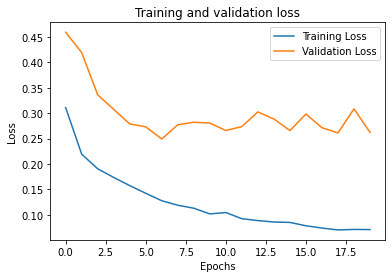

MAE of CNN: 0.26232492886503606
RMSE of CNN: 0.3873641061826405
R2 score of CNN: 0.6184739793998231
AGM score of CNN: 0.12393663608465445


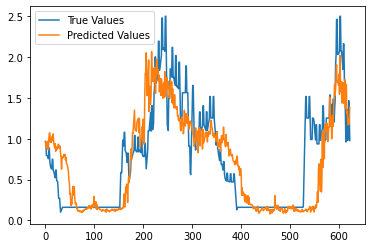

MAE of CNN: 0.2493765317347676
RMSE of CNN: 0.3692463292283258
R2 score of CNN: 0.6533287835648032
AGM score of CNN: 0.10722936986234861


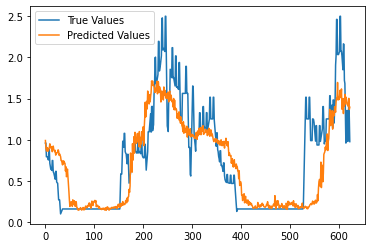

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print('End Train:', np.round(np.min(train_loss),3), ' End Val:', np.round(val_loss[-1],3), ' Min Val:', np.round(np.min(val_loss),3))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.show();

from sklearn.metrics import r2_score
preds = model.predict(hists_val).flatten()

RMSE_CNN = np.sqrt(np.mean((preds - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds - yields_val))
r2_CNN = r2_score(yields_val, preds)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)
plt.plot(yields_val, label='True Values');
plt.plot(preds, label='Predicted Values');
plt.legend(); plt.show();

#%%
#model.load_weights('Best Models/best_modelcnn0.hdf5')
model.load_weights('best_s2p_sm.hdf5')
from sklearn.metrics import r2_score
preds_val = model.predict(hists_val).flatten()

RMSE_CNN = np.sqrt(np.mean((preds_val - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds_val - yields_val))
r2_CNN = r2_score(yields_val, preds_val)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)

#from scipy.stats import spearmanr
#print(spearmanr(preds_val, yields_val))
#m = 365
#num = np.mean(np.abs(yields_val - preds_val))
#den = np.sum(np.abs(yields_train[m + 1:] - yields_train[:-(m + 1)])) / (len(yields_train) - m)
#print('MASE:', num/den)

plt.plot(yields_val, label='True Values');
plt.plot(preds_val, label='Predicted Values');
plt.legend(); plt.show();
# %%


In [ ]:
np.save('author_sa_price_results',preds_val)

In [ ]:

preds_val = np.load('author_sa_results.npy')

RMSE_CNN = np.sqrt(np.mean((preds_val - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds_val - yields_val))
r2_CNN = r2_score(yields_val, preds_val)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)

MAE of CNN: 63.77464700515949
RMSE of CNN: 91.95070995573757
R2 score of CNN: 0.8307223782556874
AGM score of CNN: 13.180409035812394


# DCN-GRU

In [ ]:
# CNN-LSTM
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()
from numpy.random import seed
seed(1)
tf.random.set_seed(3)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=(hists_train.shape[1], hists_train.shape[2])))
model.add(layers.Conv1D(filters=32, kernel_size=3, strides=1, dilation_rate=3, padding='causal', activation='linear'))#, input_shape=(hists_train.shape[1], hists_train.shape[2])))
model.add(layers.Conv1D(filters=64, kernel_size=3, strides=1, dilation_rate=3, padding='causal', activation='linear'))
model.add(layers.Conv1D(filters=128, kernel_size=3, strides=1, dilation_rate=3, padding='causal', activation='linear'))
model.add(layers.MaxPool1D(pool_size=3, strides=3, padding='same'))
#model.add(layers.Dropout(0.3))
#model.add(layers.BatchNormalization()) # <--- This is good
#model.add(layers.GRU(128))
model.add(layers.LSTM(64))
#model.add(layers.Dropout(0.3))
#model.add(layers.Flatten())

model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(units=256, activation='relu'))
#model.add(layers.Dense(units=512, activation='linear'))
#model.add(layers.Dense(units=1024, activation='relu'))
#model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=1, activation='linear'))
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
loss = 'mean_absolute_error'
model.compile(optimizer=optimizer, loss = loss)
model.summary()

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
def decay_schedule(epoch, lr):
    # decay by 0.1 in these specific epochs
    if (epoch %10 == 0) and (epoch != 0):
        lr = lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(decay_schedule)
mcp_save = ModelCheckpoint('best_s2p_sm.hdf5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(hists_train, yields_train, validation_data=(hists_val, yields_val), epochs=20\
                    , batch_size=32, callbacks=[mcp_save], verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 560)           2240      
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 32)            53792     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           24704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 128)               8

End Train: 14.316  End Val: 41.26  Min Val: 36.858


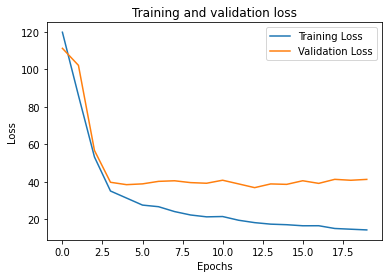

MAE of CNN: 41.25989370575587
RMSE of CNN: 58.14671416468362
R2 score of CNN: 0.7900068713333583
AGM score of CNN: 10.437352298425798


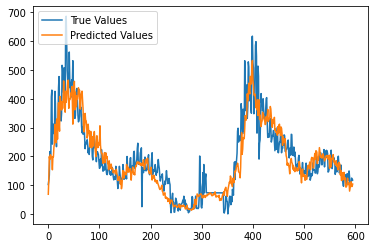

MAE of CNN: 36.8584633885864
RMSE of CNN: 51.9085979434506
R2 score of CNN: 0.8326470680443195
AGM score of CNN: 7.427713987503052


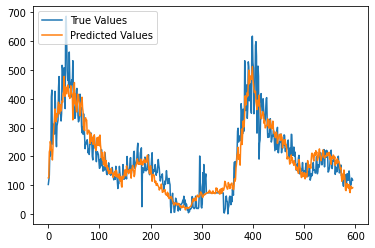

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print('End Train:', np.round(np.min(train_loss),3), ' End Val:', np.round(val_loss[-1],3), ' Min Val:', np.round(np.min(val_loss),3))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.show();

from sklearn.metrics import r2_score
preds = model.predict(hists_val).flatten()

RMSE_CNN = np.sqrt(np.mean((preds - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds - yields_val))
r2_CNN = r2_score(yields_val, preds)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)
plt.plot(yields_val, label='True Values');
plt.plot(preds, label='Predicted Values');
plt.legend(); plt.show();

#%%
#model.load_weights('Best Models/best_modelcnn0.hdf5')
model.load_weights('best_s2p_sm.hdf5')
from sklearn.metrics import r2_score
preds_val = model.predict(hists_val).flatten()

RMSE_CNN = np.sqrt(np.mean((preds_val - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds_val - yields_val))
r2_CNN = r2_score(yields_val, preds_val)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)

#from scipy.stats import spearmanr
#print(spearmanr(preds_val, yields_val))
#m = 365
#num = np.mean(np.abs(yields_val - preds_val))
#den = np.sum(np.abs(yields_train[m + 1:] - yields_train[:-(m + 1)])) / (len(yields_train) - m)
#print('MASE:', num/den)

plt.plot(yields_val, label='True Values');
plt.plot(preds_val, label='Predicted Values');
plt.legend(); plt.show();
# %%


In [ ]:
np.save('author_sa_price_results',preds_val)

In [ ]:

preds_val = np.load('author_sa_results.npy')

RMSE_CNN = np.sqrt(np.mean((preds_val - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds_val - yields_val))
r2_CNN = r2_score(yields_val, preds_val)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)

MAE of CNN: 63.77464700515949
RMSE of CNN: 91.95070995573757
R2 score of CNN: 0.8307223782556874
AGM score of CNN: 13.180409035812394


# CNN-LSTM Enhanced

In [ ]:
pip install keras_self_attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.49.0-cp37-none-any.whl size=19468 sha256=e78075a0f89d8c1b6540d4a76bbc259fb1374a039e6296791effda7507bce83c
  Stored in directory: /root/.cache/pip/wheels/6f/9d/c5/26693a5092d9313daeae94db04818fc0a2b7a48ea381989f34
Successfully built keras-self-attention


In [ ]:
model = models.Sequential()
model.add(layers.LSTM(units=128, return_sequences=True, input_shape=hists_train.shape[1:]))
model.add(SeqSelfAttention())
#model.add(layers.Flatten())
model.add(layers.Dense(1, activation='linear'))

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-2)
loss = 'mean_absolute_error'
model.compile(optimizer=optimizer, loss = loss)
model.summary()

mcp_save = ModelCheckpoint('best_s2p_sm.hdf5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(hists_train, yields_train, validation_data=(hists_val, yields_val), epochs=20\
                    , batch_size=32, callbacks=[mcp_save], verbose=1)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 32, 128)           352768    
_________________________________________________________________
seq_self_attention_14 (SeqSe (None, None, 128)         8257      
_________________________________________________________________
dense_15 (Dense)             (None, None, 1)           129       
Total params: 361,154
Trainable params: 361,154
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
75/75 [==============================] - 3s 15ms/step - loss: 108.8169 - val_loss: 102.8372
Epoch 2/20
75/75 [==============================] - 1s 8ms/step - loss: 82.3566 - val_loss: 100.6415
Epoch 3/20
75/75 [==============================] - 1s 8ms/step - loss: 80.0882 - val_loss: 96.6962
Epoch 4/20
75/75 [==============================] - 1s 8ms/step - loss: 7

In [ ]:
# CNN-LSTM
import tensorflow as tf
from keras_self_attention import SeqSelfAttention
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()
from numpy.random import seed
seed(1)
tf.random.set_seed(3)

#model = models.Sequential()
input = layers.Input(shape=hists_train.shape[1:])
l1 = layers.BatchNormalization()(input)
l2 = layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='linear')(l1)
l3 = layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='linear')(l2)
l4 = layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='causal', activation='linear')(l3)
l5 = layers.MaxPool1D(pool_size=3, strides=3, padding='same')(l4)

l6 = layers.Conv1D(1,1, padding='causal', activation='linear')(l5)

l7 = layers.Flatten()(layers.Dense(1)(l6))

ll1 = layers.LSTM(64,return_sequences=True)(input)
print(ll1.get_shape)
ls = SeqSelfAttention()(ll1)
print(ls.get_shape)
#ll2 = layers.LSTM(128)(ll1)
ll3 = layers.Flatten()(layers.Dense(1)(ls))
lcon = layers.Concatenate()([l7,ll3])
lf1 = layers.Dense(units=128, activation='relu')(lcon)
lf2 = layers.Dense(units=256, activation='relu')(lf1)
lf3 = layers.Dense(units=1, activation='linear')(lf2)

model = tf.keras.Model(inputs=input, outputs=lf3)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
loss = 'mean_absolute_error'
model.compile(optimizer=optimizer, loss = loss)
model.summary()

mcp_save = ModelCheckpoint('best_s2p_sm.hdf5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(hists_train, yields_train, validation_data=(hists_val, yields_val), epochs=20\
                    , batch_size=32, callbacks=[mcp_save], verbose=1)

<bound method KerasTensor.get_shape of <KerasTensor: shape=(None, 32, 64) dtype=float32 (created by layer 'lstm')>>
<bound method KerasTensor.get_shape of <KerasTensor: shape=(None, None, 64) dtype=float32 (created by layer 'seq_self_attention')>>


ValueError: ignored

End Train: 0.061  End Val: 0.308  Min Val: 0.292


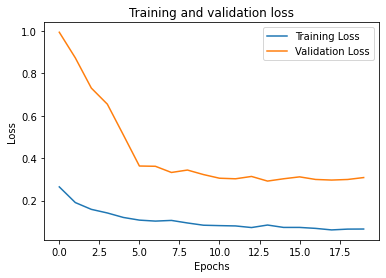

MAE of CNN: 0.30838115601031574
RMSE of CNN: 0.4209892094188742
R2 score of CNN: 0.2700594315710808
AGM score of CNN: 0.26619850956829566


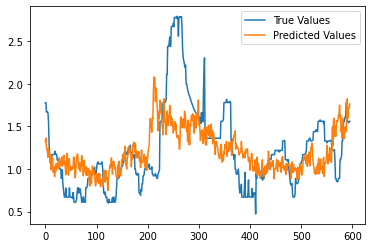

MAE of CNN: 0.29174756089412923
RMSE of CNN: 0.3959708218015103
R2 score of CNN: 0.35423880702641497
AGM score of CNN: 0.2220509216197003


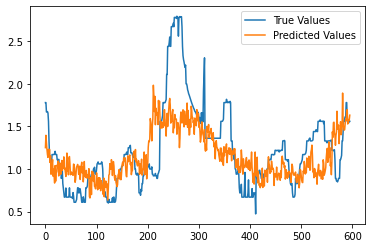

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print('End Train:', np.round(np.min(train_loss),3), ' End Val:', np.round(val_loss[-1],3), ' Min Val:', np.round(np.min(val_loss),3))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.show();

from sklearn.metrics import r2_score
preds = model.predict(hists_val).flatten()

RMSE_CNN = np.sqrt(np.mean((preds - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds - yields_val))
r2_CNN = r2_score(yields_val, preds)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)
plt.plot(yields_val, label='True Values');
plt.plot(preds, label='Predicted Values');
plt.legend(); plt.show();

#%%
#model.load_weights('Best Models/best_modelcnn0.hdf5')
model.load_weights('best_s2p_sm.hdf5')
from sklearn.metrics import r2_score
preds_val = model.predict(hists_val).flatten()

RMSE_CNN = np.sqrt(np.mean((preds_val - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds_val - yields_val))
r2_CNN = r2_score(yields_val, preds_val)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)

#from scipy.stats import spearmanr
#print(spearmanr(preds_val, yields_val))
#m = 365
#num = np.mean(np.abs(yields_val - preds_val))
#den = np.sum(np.abs(yields_train[m + 1:] - yields_train[:-(m + 1)])) / (len(yields_train) - m)
#print('MASE:', num/den)

plt.plot(yields_val, label='True Values');
plt.plot(preds_val, label='Predicted Values');
plt.legend(); plt.show();
# %%

In [ ]:
np.save('author_sa_price_results',preds_val)

In [ ]:

preds_val = np.load('author_sa_results.npy')

RMSE_CNN = np.sqrt(np.mean((preds_val - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds_val - yields_val))
r2_CNN = r2_score(yields_val, preds_val)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)

MAE of CNN: 63.77464700515949
RMSE of CNN: 91.95070995573757
R2 score of CNN: 0.8307223782556874
AGM score of CNN: 13.180409035812394


# ConvLSTM

In [ ]:
pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.49.0-cp37-none-any.whl size=19468 sha256=adb79215360a3633ab832d59bff9ecefcf31bf1afdf77a80d4c53450d82f2301
  Stored in directory: /root/.cache/pip/wheels/6f/9d/c5/26693a5092d9313daeae94db04818fc0a2b7a48ea381989f34
Successfully built keras-self-attention


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
tf.keras.backend.clear_session()
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

model = models.Sequential()
#model.add(layers.BatchNormalization(input_shape=(hists_train.shape[1:])))
#model.add(layers.ConvLSTM2D(filters=64, kernel_size=3, strides=3, activation='relu',input_shape=(hists_train.shape[1:])))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same',input_shape=(hists_train.shape[1:])))
model.add(layers.MaxPool2D(pool_size=3, strides=3, padding='same'))
#model.add(SeqSelfAttention(attention_activation='sigmoid'))
#model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization()) # <--- This is good
#model.add(layers.LSTM(64))
#model.add(layers.Dropout(0.3))
model.add(layers.Flatten())

model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(units=256, activation='relu'))
#model.add(layers.Dense(units=512, activation='linear'))
#model.add(layers.Dense(units=1024, activation='relu'))
#model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=1, activation='linear'))
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
loss = 'mean_absolute_error'
model.compile(optimizer=optimizer, loss = loss)
model.summary()

mcp_save = ModelCheckpoint('best_ConvLSTM.hdf5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(hists_train, yields_train, validation_data=(hists_val, yields_val), epochs=20, batch_size=32, callbacks=[mcp_save], verbose=1)

ValueError: ignored

MAE of CNN: 46.42486224095993
RMSE of CNN: 69.68088345766395
R2 score of CNN: 0.6984342436605553
AGM score of CNN: 17.50675850848037


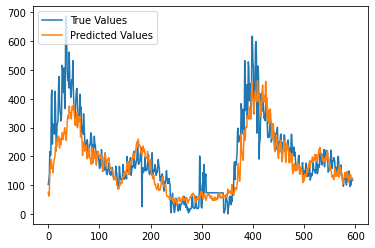

In [ ]:
from sklearn.metrics import r2_score

model = models.load_model('best_ConvLSTM.hdf5')
preds = model.predict(hists_val).flatten()
RMSE_CNN = np.sqrt(np.mean((preds - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds - yields_val))
r2_CNN = r2_score(yields_val, preds)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)

plt.plot(yields_val, label='True Values');
plt.plot(preds, label='Predicted Values');
plt.legend();
plt.show()

# SAE

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K
from tensorflow.keras import layers, models
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from numpy.random import seed
tf.random.set_seed(1)
seed(1)

n_past = hists_train.shape[1]
n_features = hists_train.shape[2]
n_future = 64
n = 100
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(n,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(n, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
decoder_l1 = tf.keras.layers.LSTM(n, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(n, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.Dense(1)(tf.keras.layers.Flatten()(decoder_l2))
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
model_e2d2.summary()
l1 = tf.keras.losses.Huber()
l2 = 'mean_absolute_error'
model_e2d2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=5e-4), loss=l2)

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
def decay_schedule(epoch, lr):
    # decay by 0.1 in these specific epochs
    if (epoch %10 == 0) and (epoch != 0):
        lr = lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(decay_schedule)
mcp_save = ModelCheckpoint('best_s2y_sae_sm.hdf5', save_best_only=True, monitor='val_loss', mode='min')
history = model_e2d2.fit(hists_train, yields_train, validation_data=(hists_val, yields_val), epochs=20\
                    , batch_size=32, callbacks=[mcp_save], verbose=1)

NameError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from numpy.random import seed
tf.random.set_seed(1)
seed(1)

n_past = hists_train.shape[1]
n_features = hists_train.shape[2]
n_future = 64
n = 100
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(n,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(n, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
decoder_l1 = tf.keras.layers.LSTM(n, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(n, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.Dense(1)(tf.keras.layers.Flatten()(decoder_l2))
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
model_e2d2.summary()
l1 = tf.keras.losses.Huber()
l2 = 'mean_absolute_error'
model_e2d2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=5e-4), loss=l2)

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
def decay_schedule(epoch, lr):
    # decay by 0.1 in these specific epochs
    if (epoch %10 == 0) and (epoch != 0):
        lr = lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(decay_schedule)
mcp_save = ModelCheckpoint('best_s2y_vae_sm.hdf5', save_best_only=True, monitor='val_loss', mode='min')
history = model_e2d2.fit(hists_train, yields_train, validation_data=(hists_val, yields_val), epochs=20\
                    , batch_size=32, callbacks=[mcp_save], verbose=1)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 560)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 32, 100), (N 264400      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 100), (None, 80400       lstm[0][0]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 64, 100)      0           lstm_1[0][0]                     
______________________________________________________________________________________________

MAE of CNN: 40.56014348214005
RMSE of CNN: 55.06875880746524
R2 score of CNN: 0.8116501389640461
AGM score of CNN: 9.005845228633984


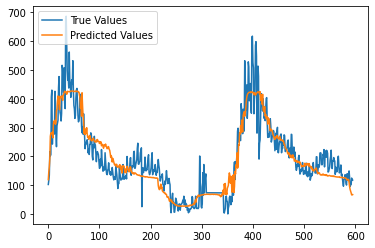

In [ ]:
from sklearn.metrics import r2_score

model = models.load_model('best_s2y_vae_sm.hdf5')
preds = model.predict(hists_val).flatten()
RMSE_CNN = np.sqrt(np.mean((preds - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds - yields_val))
r2_CNN = r2_score(yields_val, preds)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)

plt.plot(yields_val, label='True Values');
plt.plot(preds, label='Predicted Values');
plt.legend();
plt.show()

1
MAE of CNN: 0.161317175620536
RMSE of CNN: 0.29306420518779686
R2 score of CNN: 0.23646450280973041
AGM score of CNN: 0.1734681567547458


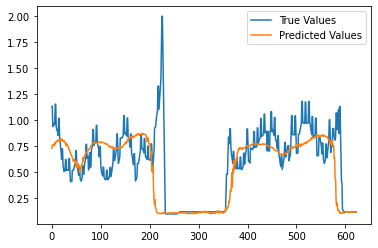

2
MAE of CNN: 0.16211439530182292
RMSE of CNN: 0.24943910349132095
R2 score of CNN: 0.44686294601471277
AGM score of CNN: 0.11382274493988853


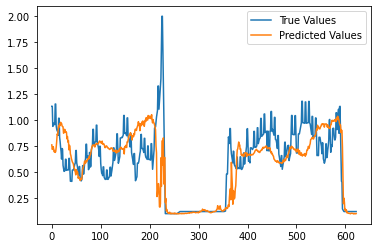

3
MAE of CNN: 0.15967052122531183
RMSE of CNN: 0.28742916281872943
R2 score of CNN: 0.26554475219405405
AGM score of CNN: 0.16418735461926323


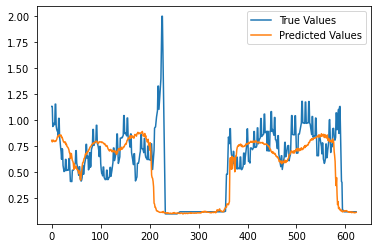

4
MAE of CNN: 0.16444286517850723
RMSE of CNN: 0.28271885827181276
R2 score of CNN: 0.28941958215831765
AGM score of CNN: 0.1588721821460676


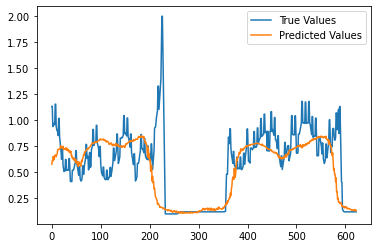

5
MAE of CNN: 0.1662378059666446
RMSE of CNN: 0.2839772438742027
R2 score of CNN: 0.2830798976691873
AGM score of CNN: 0.1613841098013861


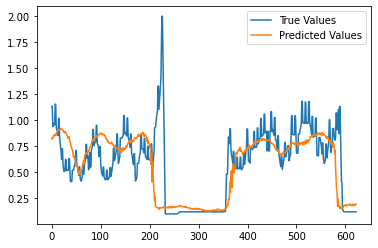

6
MAE of CNN: 0.15903965485724236
RMSE of CNN: 0.26791055740019226
R2 score of CNN: 0.36190794923638525
AGM score of CNN: 0.13621676825665352


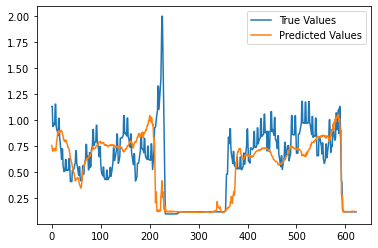

7
MAE of CNN: 0.1617236886307031
RMSE of CNN: 0.2797930317200987
R2 score of CNN: 0.3040509174223893
AGM score of CNN: 0.153636578235408


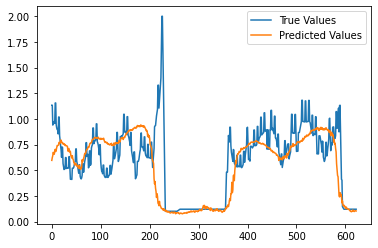

8
MAE of CNN: 0.1662682218949319
RMSE of CNN: 0.28449921912131626
R2 score of CNN: 0.2804419506129082
AGM score of CNN: 0.16217667029243124


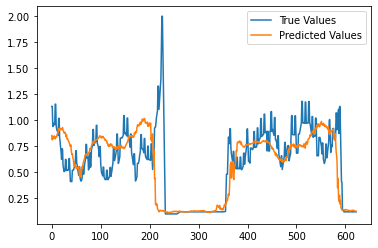

9
MAE of CNN: 0.15532559586757638
RMSE of CNN: 0.28021588719357393
R2 score of CNN: 0.3019457309108844
AGM score of CNN: 0.15201579580812036


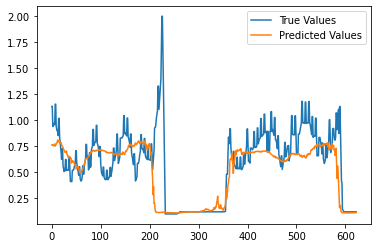

10
MAE of CNN: 0.15887443366552687
RMSE of CNN: 0.26532663539596063
R2 score of CNN: 0.37415703039542836
AGM score of CNN: 0.13274162838543765


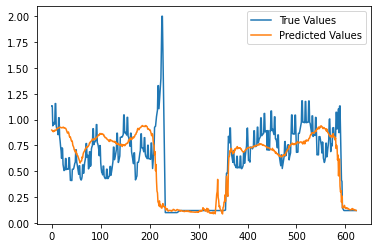

11
MAE of CNN: 0.1715566195500541
RMSE of CNN: 0.29792275273018026
R2 score of CNN: 0.2109381932275055
AGM score of CNN: 0.18522412086692916


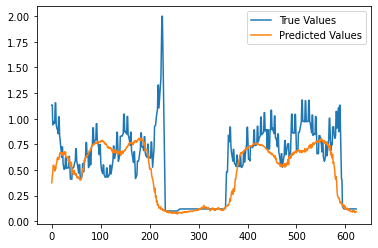

12
MAE of CNN: 0.14220268810828654
RMSE of CNN: 0.23350473387854578
R2 score of CNN: 0.5152754039042884
AGM score of CNN: 0.09105731418636419


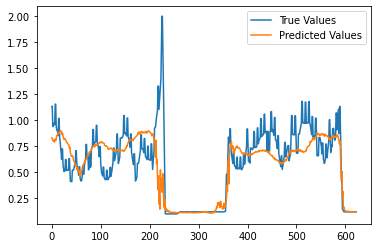

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from numpy.random import seed
agm_CNN = 10
i = 1
while agm_CNN > 0.105:
    tf.keras.backend.clear_session()
    print(i)
    tf.random.set_seed(i)
    seed(1)

    n_past = hists_train.shape[1]
    n_features = hists_train.shape[2]
    n_future = 8
    n = 100
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
    encoder_l1 = tf.keras.layers.LSTM(n,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tf.keras.layers.LSTM(n, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
    decoder_l1 = tf.keras.layers.LSTM(n, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(n, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
    decoder_outputs2 = tf.keras.layers.Dense(1)(tf.keras.layers.Flatten()(decoder_l2))
    model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
    #model_e2d2.summary()
    l1 = tf.keras.losses.Huber()
    l2 = 'mean_absolute_error'
    model_e2d2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=5e-4), loss=l2)

    from tensorflow.keras.callbacks import LearningRateScheduler
    from tensorflow.keras.callbacks import ModelCheckpoint
    def decay_schedule(epoch, lr):
        # decay by 0.1 in these specific epochs
        if (epoch %10 == 0) and (epoch != 0):
            lr = lr * 0.5
        return lr

    lr_scheduler = LearningRateScheduler(decay_schedule)
    mcp_save = ModelCheckpoint('best_s2y_vae_sm.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    history = model_e2d2.fit(hists_train, yields_train, validation_data=(hists_val, yields_val), epochs=20\
                        , batch_size=32, callbacks=[mcp_save], verbose=0)


    from sklearn.metrics import r2_score

    model = models.load_model('best_s2y_vae_sm.hdf5')
    preds = model.predict(hists_val).flatten()
    RMSE_CNN = np.sqrt(np.mean((preds - yields_val)**2))
    MAE_CNN = np.mean(np.abs(preds - yields_val))
    r2_CNN = r2_score(yields_val, preds)
    agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
    print ("MAE of CNN:",MAE_CNN)
    print ("RMSE of CNN:", RMSE_CNN)
    print ("R2 score of CNN:",r2_CNN)
    print ("AGM score of CNN:",agm_CNN)

    plt.plot(yields_val, label='True Values');
    plt.plot(preds, label='Predicted Values');
    plt.legend();
    plt.show()
    i += 1

# VAE

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model, Sequential

In [ ]:
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from numpy.random import seed
tf.keras.backend.clear_session()
tf.random.set_seed(1)
seed(1)

latent_dim = 16

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs = keras.Input(shape= lagged_hists.shape[1:])
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
#x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 140 * 32, activation="relu")(latent_inputs)
x = layers.Reshape((8, 140, 32))(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 560, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 280, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 140, 32)   4640        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 35840)        0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [ ]:
mnist_digits = np.concatenate([hists_train, hists_val], axis=0)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=20, batch_size=32)

Epoch 1/20
94/94 [==============================] - 4s 36ms/step - loss: 7597.7273 - reconstruction_loss: 4160.2676 - kl_loss: 120.9539
Epoch 2/20
94/94 [==============================] - 3s 35ms/step - loss: 1690.3493 - reconstruction_loss: 1599.8386 - kl_loss: 45.3849
Epoch 3/20
94/94 [==============================] - 3s 35ms/step - loss: 1572.8628 - reconstruction_loss: 1528.2031 - kl_loss: 27.0227
Epoch 4/20
94/94 [==============================] - 3s 35ms/step - loss: 1480.0136 - reconstruction_loss: 1434.8469 - kl_loss: 27.1662
Epoch 5/20
94/94 [==============================] - 3s 36ms/step - loss: 1389.2221 - reconstruction_loss: 1335.0341 - kl_loss: 27.9453
Epoch 6/20
94/94 [==============================] - 3s 35ms/step - loss: 1331.8737 - reconstruction_loss: 1297.5474 - kl_loss: 26.3291
Epoch 7/20
94/94 [==============================] - 3s 35ms/step - loss: 1304.6881 - reconstruction_loss: 1275.3932 - kl_loss: 25.6954
Epoch 8/20
94/94 [==============================] - 3s

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from numpy.random import seed
tf.random.set_seed(1)
seed(1)

new = vae.layers[0].layers[-1].output
out = layers.Dense(1,activation='linear')(new)
final_model = Model(encoder_inputs, out)
final_model.summary()
final_model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(5e-4))
#keras.utils.plot_model(final_model)
mcp_save = ModelCheckpoint('best_s2y_vae_ox.hdf5', save_best_only=True, monitor='val_loss', mode='min')
history = final_model.fit(hists_train, yields_train, validation_data=(hists_val, yields_val), epochs=20\
                    , batch_size=32, callbacks=[mcp_save], verbose=1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 560, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 280, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 140, 32)   4640        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 35840)        0           conv2d_1[0][0]                   
______________________________________________________________________________________________

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 560, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 280, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 140, 32)   4640        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 35840)        0           conv2d_1[0][0]                   
______________________________________________________________________________________________

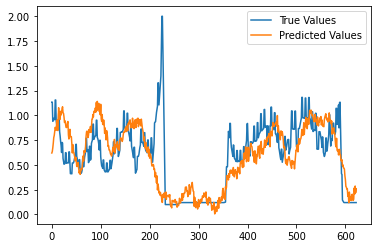

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 560, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 280, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 140, 32)   4640        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 35840)        0           conv2d_1[0][0]                   
______________________________________________________________________________________________

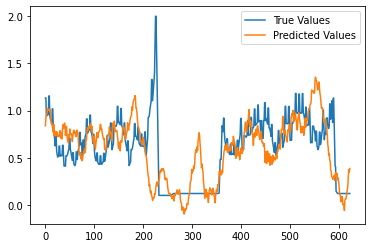

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 560, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 280, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 140, 32)   4640        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 35840)        0           conv2d_1[0][0]                   
______________________________________________________________________________________________

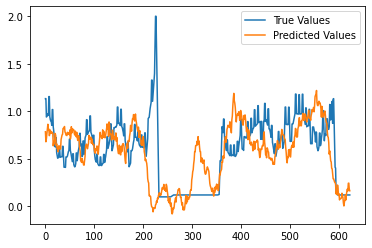

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 560, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 280, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 140, 32)   4640        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 35840)        0           conv2d_1[0][0]                   
______________________________________________________________________________________________

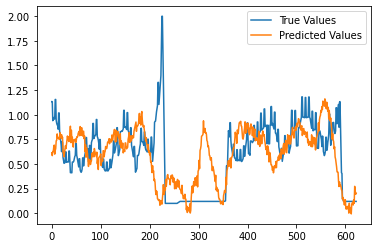

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 560, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 280, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 140, 32)   4640        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 35840)        0           conv2d_1[0][0]                   
______________________________________________________________________________________________

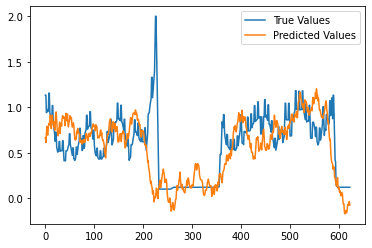

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 560, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 280, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 140, 32)   4640        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 35840)        0           conv2d_1[0][0]                   
______________________________________________________________________________________________

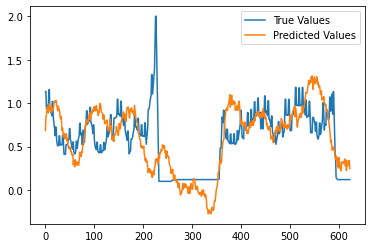

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 560, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 280, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 140, 32)   4640        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 35840)        0           conv2d_1[0][0]                   
______________________________________________________________________________________________

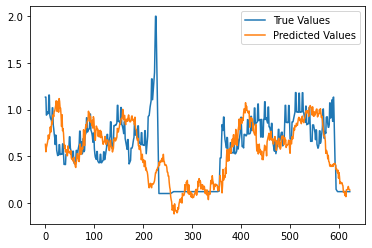

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 560, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 280, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 140, 32)   4640        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 35840)        0           conv2d_1[0][0]                   
______________________________________________________________________________________________

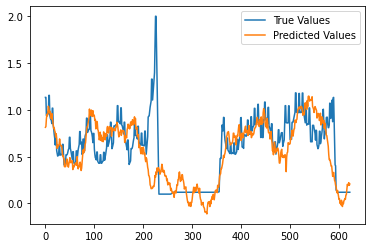

In [ ]:
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from numpy.random import seed
tf.keras.backend.clear_session()
tf.random.set_seed(1)
seed(1)

latent_dim = 16

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
agm_CNN = 100
while agm_CNN > 0.16:
    tf.keras.backend.clear_session()

    encoder_inputs = keras.Input(shape= lagged_hists.shape[1:])
    x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    #x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(8 * 140 * 32, activation="relu")(latent_inputs)
    x = layers.Reshape((8, 140, 32))(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    class VAE(keras.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
            self.reconstruction_loss_tracker = keras.metrics.Mean(
                name="reconstruction_loss"
            )
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        @property
        def metrics(self):
            return [
                self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
            ]

        def train_step(self, data):
            with tf.GradientTape() as tape:
                z_mean, z_log_var, z = self.encoder(data)
                reconstruction = self.decoder(z)
                reconstruction_loss = tf.reduce_mean(
                    tf.reduce_sum(
                        keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                    )
                )
                kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
                total_loss = reconstruction_loss + kl_loss
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }

    mnist_digits = np.concatenate([hists_train, hists_val], axis=0)
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    vae.fit(mnist_digits, epochs=20, batch_size=32, verbose=0)
    
    from tensorflow.keras.callbacks import ModelCheckpoint

    new = vae.layers[0].layers[-1].output
    out = layers.Dense(1,activation='linear')(new)
    final_model = Model(encoder_inputs, out)
    final_model.summary()
    final_model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(5e-4))
    #keras.utils.plot_model(final_model)
    mcp_save = ModelCheckpoint('best_s2y_vae_ox.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    history = final_model.fit(hists_train, yields_train, validation_data=(hists_val, yields_val), epochs=20\
                        , batch_size=32, callbacks=[mcp_save], verbose=0)
    
    from tensorflow.keras import layers, models
    from sklearn.metrics import r2_score

    model = models.load_model('best_s2y_vae_ox.hdf5', custom_objects={'Sampling': Sampling})
    preds = model.predict(hists_val).flatten()
    RMSE_CNN = np.sqrt(np.mean((preds - yields_val)**2))
    MAE_CNN = np.mean(np.abs(preds - yields_val))
    r2_CNN = r2_score(yields_val, preds)
    agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
    print ("AGM score of CNN:",agm_CNN)

    plt.plot(yields_val, label='True Values');
    plt.plot(preds, label='Predicted Values');
    plt.legend();
    plt.show()

MAE of CNN: 0.17242842300794023
RMSE of CNN: 0.27044226048272696
R2 score of CNN: 0.34979127478764627
AGM score of CNN: 0.14397919127319525


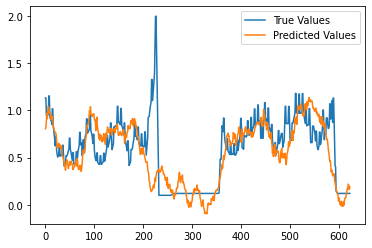

In [ ]:
from tensorflow.keras import layers, models
from sklearn.metrics import r2_score

model = models.load_model('best_s2y_vae_ox.hdf5', custom_objects={'Sampling': Sampling})
preds = model.predict(hists_val).flatten()
RMSE_CNN = np.sqrt(np.mean((preds - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds - yields_val))
r2_CNN = r2_score(yields_val, preds)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)

plt.plot(yields_val, label='True Values');
plt.plot(preds, label='Predicted Values');
plt.legend();
plt.show()

# SeriesNet

In [ ]:
pip install keras-self-attention

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
#from keras_self_attention import SeqSelfAttention
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
tf.keras.backend.clear_session()
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

def DCCNN_Block(n_filters, filter_width, dilation_rate, l2reg,input1):
    residual = input1
    layer_1 = layers.Conv1D(filters=n_filters, kernel_size=filter_width, dilation_rate=dilation_rate, 
                    activation='relu', padding='causal', use_bias=False, 
                    kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=10), 
                    kernel_regularizer=tf.keras.regularizers.l2(l2reg))(input1)    
    layer_1 = layers.Activation('relu')(layer_1)
    skip = layers.Conv1D(1,1, activation='relu', use_bias=False, 
                  kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=10),
                  kernel_regularizer=tf.keras.regularizers.l2(l2reg))(layer_1)
    layer_2 = layers.Conv1D(1,1, activation='relu', use_bias=False, 
                     kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=10),
                     kernel_regularizer=tf.keras.regularizers.l2(l2reg))(layer_1)  
    To_Next_Layer = layers.Add()([residual, layer_2])
    return To_Next_Layer, skip

def Model_Build_SN_GRU(length):
    input1 = layers.Input(shape=length)
    n_filters = 32
    filter_width = 3
    dilation_rates = [2**i for i in range(7)] #for 7 layers.
    l2reg = 0.01
    l1a, l1b = DCCNN_Block(n_filters,filter_width,dilation_rates[0],l2reg,input1) 
    l2a, l2b = DCCNN_Block(n_filters,filter_width,dilation_rates[1],l2reg,l1a) 
    l3a, l3b = DCCNN_Block(n_filters,filter_width,dilation_rates[2],l2reg,l2a)
    l4a, l4b = DCCNN_Block(n_filters,filter_width,dilation_rates[3],l2reg,l3a)
    l5a, l5b = DCCNN_Block(n_filters,filter_width,dilation_rates[4],l2reg,l4a)
    l6a, l6b = DCCNN_Block(n_filters,filter_width,dilation_rates[5],l2reg,l5a)
    l6b = layers.Dropout(0.5)(l6b)
    l7a, l7b = DCCNN_Block(n_filters,filter_width,dilation_rates[6],l2reg,l6a)
    l7b = layers.Dropout(0.5)(l7b) 
    l8 = layers.Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b])
    l9 = layers.Activation('relu')(l8)
    l10 = layers.Conv1D(1,1, activation='linear', use_bias=False, 
    kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=10),
    kernel_regularizer=tf.keras.regularizers.l2(0.001))(l9)
    #l10a = SeqSelfAttention()(l10)
    l11 = layers.Flatten()(l10)
    l12 = layers.Dense(1)(l11)
    #layers.reshape(l12a)
    print(tf.shape(l12))

    #SECOND NETWORK#
    ls2 = layers.LSTM(100,return_sequences=True)(input1)
    #ls3= SeqSelfAttention()(ls2)
    ls4 = layers.LSTM(100,return_sequences=True)(ls2)
    ls4a = layers.Dropout(0.6)(ls4) #initially was 0.6
    ls4b= layers.LSTM(100)(ls4a)
    ls5 = layers.Dense(1)(ls4b)
    print(tf.shape(ls5))

    l13 = layers.Concatenate()([l12,ls5])
    output= layers.Dense(1,activation='relu')(l13)
    model = tf.keras.Model(inputs=input1, outputs=output)
    adam = tf.keras.optimizers.Adam(lr=5e-4, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=True)
    #adam = tf.keras.optimizers.RMSprop(lr=5e-4)
    model.compile(loss='mean_absolute_error', optimizer=adam)
    return model

In [ ]:
seriesnet = Model_Build_SN_GRU(hists_train.shape[1:])
#seriesnet.summary()
mcp_save = ModelCheckpoint('best_SNet.hdf5', save_best_only=True, monitor='val_loss', mode='min')
history = seriesnet.fit(hists_train, yields_train, validation_data=(hists_val, yields_val), epochs=20, batch_size=32, callbacks=[mcp_save], verbose=1)

KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape/Shape:0', description="created by layer 'tf.compat.v1.shape'")
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_1/Shape:0', description="created by layer 'tf.compat.v1.shape_1'")
Epoch 1/20
78/78 [==============================] - 9s 43ms/step - loss: 115.3416 - val_loss: 100.5598
Epoch 2/20
78/78 [==============================] - 2s 24ms/step - loss: 46.0321 - val_loss: 76.0842
Epoch 3/20
78/78 [==============================] - 2s 25ms/step - loss: 41.9700 - val_loss: 79.0228
Epoch 4/20
78/78 [==============================] - 2s 24ms/step - loss: 32.9381 - val_loss: 69.7477
Epoch 5/20
78/78 [==============================] - 2s 26ms/step - loss: 38.1578 - val_loss: 86.4827
Epoch 6/20
78/78 [==============================] - 2s 26ms/step - loss: 27.9449 - val_loss: 76.4999
Epoch 7/20
78/

MAE of CNN: 59.13652481112396
RMSE of CNN: 92.91990778066388
R2 score of CNN: 0.8271350617280331
AGM score of CNN: 13.14261291691745


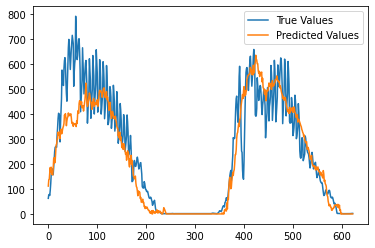

In [ ]:
from sklearn.metrics import r2_score

model = models.load_model('best_SNet.hdf5')
preds = model.predict(hists_val).flatten()
RMSE_CNN = np.sqrt(np.mean((preds - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds - yields_val))
r2_CNN = r2_score(yields_val, preds)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)

plt.plot(yields_val, label='True Values');
plt.plot(preds, label='Predicted Values');
plt.legend();
plt.show()

1
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape/Shape:0', description="created by layer 'tf.compat.v1.shape'")
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_1/Shape:0', description="created by layer 'tf.compat.v1.shape_1'")
MAE of CNN: 62.25706720333038
RMSE of CNN: 92.86319610105451
R2 score of CNN: 0.8273460061760554
AGM score of CNN: 13.391066491261967


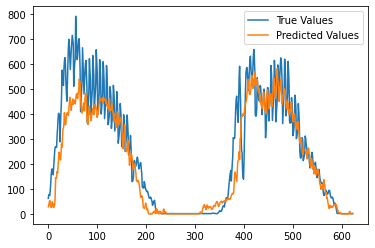

2
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_2/Shape:0', description="created by layer 'tf.compat.v1.shape_2'")
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_3/Shape:0', description="created by layer 'tf.compat.v1.shape_3'")
MAE of CNN: 62.47854448742507
RMSE of CNN: 95.9009949943772
R2 score of CNN: 0.8158653157593703
AGM score of CNN: 14.581583246329007


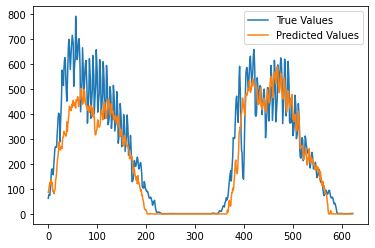

3
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_4/Shape:0', description="created by layer 'tf.compat.v1.shape_4'")
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_5/Shape:0', description="created by layer 'tf.compat.v1.shape_5'")
MAE of CNN: 64.91619989597635
RMSE of CNN: 101.23351744350586
R2 score of CNN: 0.7948185808630055
AGM score of CNN: 17.04541739646273


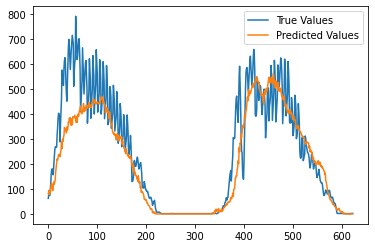

4
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_6/Shape:0', description="created by layer 'tf.compat.v1.shape_6'")
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_7/Shape:0', description="created by layer 'tf.compat.v1.shape_7'")
MAE of CNN: 64.27763726240559
RMSE of CNN: 103.95928906124982
R2 score of CNN: 0.7836205677465772
AGM score of CNN: 18.201505300986742


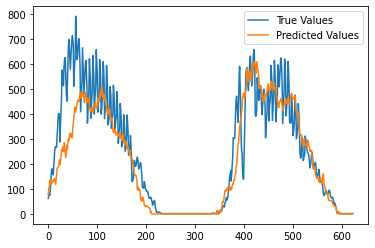

5
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_8/Shape:0', description="created by layer 'tf.compat.v1.shape_8'")
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_9/Shape:0', description="created by layer 'tf.compat.v1.shape_9'")
MAE of CNN: 64.76176663601763
RMSE of CNN: 98.69461559050077
R2 score of CNN: 0.8049812830332246
AGM score of CNN: 15.938526970923226


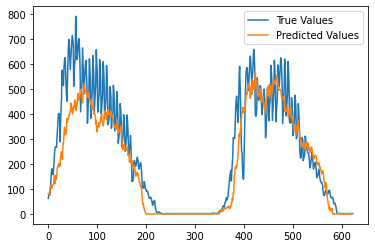

6
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_10/Shape:0', description="created by layer 'tf.compat.v1.shape_10'")
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_11/Shape:0', description="created by layer 'tf.compat.v1.shape_11'")
MAE of CNN: 78.02500831296318
RMSE of CNN: 120.02942475672845
R2 score of CNN: 0.7115537981598885
AGM score of CNN: 28.564024488274562


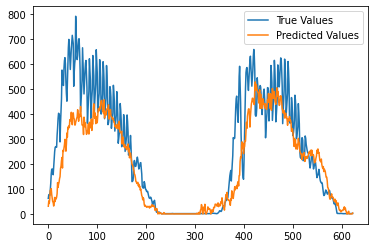

7
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_12/Shape:0', description="created by layer 'tf.compat.v1.shape_12'")
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_13/Shape:0', description="created by layer 'tf.compat.v1.shape_13'")
MAE of CNN: 64.03099163687439
RMSE of CNN: 101.74024665446261
R2 score of CNN: 0.7927593491340768
AGM score of CNN: 17.17726965917337


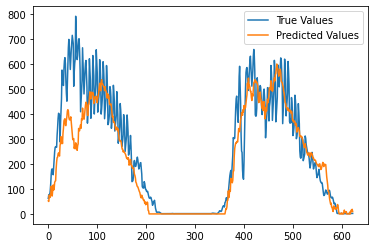

8
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_14/Shape:0', description="created by layer 'tf.compat.v1.shape_14'")
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_15/Shape:0', description="created by layer 'tf.compat.v1.shape_15'")
MAE of CNN: 62.347540797238175
RMSE of CNN: 93.67238005741764
R2 score of CNN: 0.8243239793751096
AGM score of CNN: 13.704479416978142


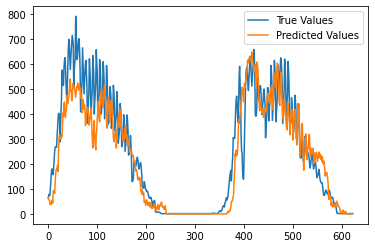

9
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_16/Shape:0', description="created by layer 'tf.compat.v1.shape_16'")
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_17/Shape:0', description="created by layer 'tf.compat.v1.shape_17'")
MAE of CNN: 69.46533261952297
RMSE of CNN: 111.49770561883625
R2 score of CNN: 0.7511020976557503
AGM score of CNN: 22.520660309684928


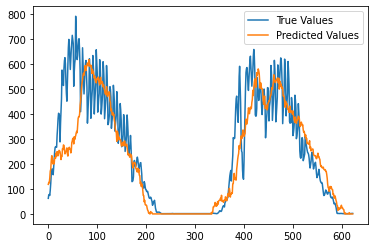

10
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_18/Shape:0', description="created by layer 'tf.compat.v1.shape_18'")
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_19/Shape:0', description="created by layer 'tf.compat.v1.shape_19'")
MAE of CNN: 72.40610868016176
RMSE of CNN: 111.13009382241398
R2 score of CNN: 0.7527406420326725
AGM score of CNN: 22.69052179727414


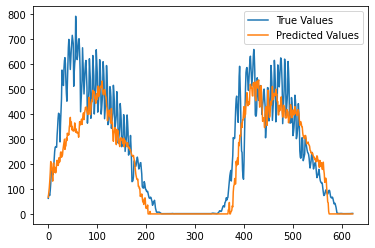

11
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_20/Shape:0', description="created by layer 'tf.compat.v1.shape_20'")
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_21/Shape:0', description="created by layer 'tf.compat.v1.shape_21'")
MAE of CNN: 59.13652481112396
RMSE of CNN: 92.91990778066388
R2 score of CNN: 0.8271350617280331
AGM score of CNN: 13.14261291691745


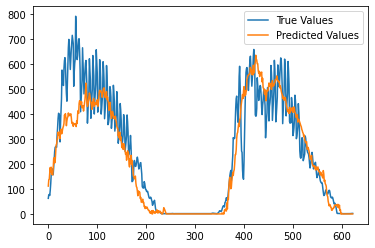

12
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_22/Shape:0', description="created by layer 'tf.compat.v1.shape_22'")
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 1], name='tf.compat.v1.shape_23/Shape:0', description="created by layer 'tf.compat.v1.shape_23'")


KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
#from keras_self_attention import SeqSelfAttention
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
tf.keras.backend.clear_session()
from numpy.random import seed
seed(1)
i=1
while agm_CNN > 8.4:
    print(i)
    tf.random.set_seed(i)
    seriesnet = Model_Build_SN_GRU(hists_train.shape[1:]);
    mcp_save = ModelCheckpoint('best_SNet.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    history = seriesnet.fit(hists_train, yields_train, validation_data=(hists_val, yields_val), epochs=20, batch_size=32, callbacks=[mcp_save], verbose=0)
    
    model = models.load_model('best_SNet.hdf5')
    preds = model.predict(hists_val).flatten()
    RMSE_CNN = np.sqrt(np.mean((preds - yields_val)**2))
    MAE_CNN = np.mean(np.abs(preds - yields_val))
    r2_CNN = r2_score(yields_val, preds)
    agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
    print ("MAE of CNN:",MAE_CNN)
    print ("RMSE of CNN:", RMSE_CNN)
    print ("R2 score of CNN:",r2_CNN)
    print ("AGM score of CNN:",agm_CNN)

    plt.plot(yields_val, label='True Values');
    plt.plot(preds, label='Predicted Values');
    plt.legend();
    plt.show()
    i += 1

# ES-RNN

In [ ]:
pip install ESRNN

     |████████████████████████████████| 17.3MB 191kB/s 
     |████████████████████████████████| 10.4MB 54.0MB/s 
ERROR: umap-learn 0.5.1 has requirement numpy>=1.17, but you'll have numpy 1.16.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.16.1 which is incompatible.
ERROR: pyarrow 3.0.0 has requirement numpy>=1.16.6, but you'll have numpy 1.16.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 0.25.2 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement pandas>=1.0.4, but you'll have pandas 0.25.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: astropy 4.2 has requirement numpy>=1.17, but you'll have numpy 1.16.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
 

In [ ]:
from ESRNN import ESRNN
import pandas as pd

model = ESRNN(max_epochs=25, freq_of_test=5, batch_size=4, learning_rate=1e-4,
              per_series_lr_multip=0.8, lr_scheduler_step_size=10,
              lr_decay=0.1, gradient_clipping_threshold=50,
              rnn_weight_decay=0.0, level_variability_penalty=100,
              testing_percentile=50, training_percentile=50,
              ensemble=False, max_periods=25, seasonality=[],
              input_size=4, output_size=6,
              cell_type='LSTM', state_hsize=40,
              dilations=[[1], [6]], add_nl_layer=False,
              random_seed=1, device='cpu')

# Fit model
# If y_test_df is provided the model
# will evaluate predictions on
# this set every freq_test epochs
model.fit(pd.DataFrame(hists_train), pd.DataFrame(yields_train))

# Predict on test set
#y_hat_df = model.predict(X_test_df)

AssertionError: ignored

End Train: 12.994  End Val: 46.7  Min Val: 43.149


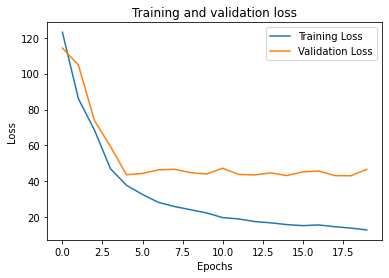

MAE of CNN: 46.70044557212683
RMSE of CNN: 66.12834327452653
R2 score of CNN: 0.7283998454177047
AGM score of CNN: 15.322158246042102


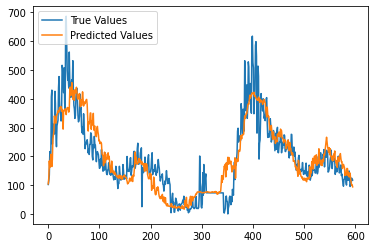

MAE of CNN: 43.14949182838502
RMSE of CNN: 62.38765912594942
R2 score of CNN: 0.7582580009059605
AGM score of CNN: 12.756380925195112


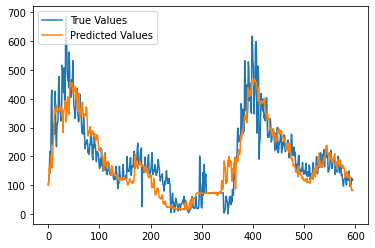

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print('End Train:', np.round(np.min(train_loss),3), ' End Val:', np.round(val_loss[-1],3), ' Min Val:', np.round(np.min(val_loss),3))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.show();

from sklearn.metrics import r2_score
preds = model.predict(hists_val).flatten()

RMSE_CNN = np.sqrt(np.mean((preds - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds - yields_val))
r2_CNN = r2_score(yields_val, preds)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)
plt.plot(yields_val, label='True Values');
plt.plot(preds, label='Predicted Values');
plt.legend(); plt.show();

#%%
#model.load_weights('Best Models/best_modelcnn0.hdf5')
model.load_weights('best_s2p_sm.hdf5')
from sklearn.metrics import r2_score
preds_val = model.predict(hists_val).flatten()

RMSE_CNN = np.sqrt(np.mean((preds_val - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds_val - yields_val))
r2_CNN = r2_score(yields_val, preds_val)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)

#from scipy.stats import spearmanr
#print(spearmanr(preds_val, yields_val))
#m = 365
#num = np.mean(np.abs(yields_val - preds_val))
#den = np.sum(np.abs(yields_train[m + 1:] - yields_train[:-(m + 1)])) / (len(yields_train) - m)
#print('MASE:', num/den)

plt.plot(yields_val, label='True Values');
plt.plot(preds_val, label='Predicted Values');
plt.legend(); plt.show();
# %%


In [ ]:
np.save('author_sa_price_results',preds_val)

In [ ]:

preds_val = np.load('author_sa_results.npy')

RMSE_CNN = np.sqrt(np.mean((preds_val - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds_val - yields_val))
r2_CNN = r2_score(yields_val, preds_val)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)

MAE of CNN: 63.77464700515949
RMSE of CNN: 91.95070995573757
R2 score of CNN: 0.8307223782556874
AGM score of CNN: 13.180409035812394


# Author CNN (2D)

In [ ]:
# CNN-LSTM

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()
from numpy.random import seed
import time
seed(1)
tf.random.set_seed(5)

#from numpy.random import seed
#seed(1)
#from tensorflow.random import set_seed
#set_seed(2)

#Things tested:
# -Strides 3 better than 1,2
# Batch size 16 better than 32 (8 even better)
# Play with the dense layers at the end (256,512)
# Adding dense layers might work with smaller layers
start = time.time()
model = models.Sequential()
''
model.add(layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(hists_train.shape[1], hists_train.shape[2], hists_train.shape[3])))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(filters=256, kernel_size=3, strides=2, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(filters=512, kernel_size=3, strides=2, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())

model.add(layers.Dense(units=2048, activation='linear'))

model.add(layers.Dense(units=1, activation='linear'))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = 'mean_absolute_error'
model.compile(optimizer=optimizer, loss = loss)
model.summary()

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
def decay_schedule(epoch, lr):
    # decay by 0.1 in these specific epochs
    if (epoch %10 == 0) and (epoch != 0):
        lr = lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(decay_schedule)
mcp_save = ModelCheckpoint('best_model_author.hdf5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(hists_train, yields_train, validation_data=(hists_val, yields_val), epochs=20\
                    , batch_size=32, callbacks=[mcp_save], verbose=1)
print("Time taken:", time.time() - start)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 140, 128)      4736      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 140, 128)      512       
_________________________________________________________________
dropout (Dropout)            (None, 32, 140, 128)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 70, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 70, 128)       512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 70, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 70, 256)       2

End Train: 0.435  End Val: 0.37  Min Val: 0.198


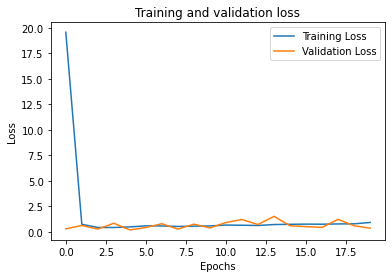

MAE of CNN: 0.3701307289273647
RMSE of CNN: 0.4592040516964982
R2 score of CNN: -1.0076072121133328
AGM score of CNN: 0.8324892434184479


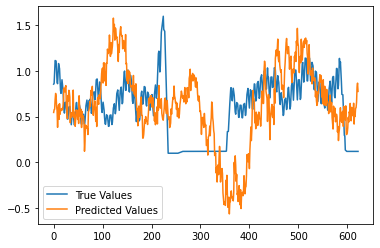

MAE of CNN: 0.19846289165970982
RMSE of CNN: 0.2679033129546451
R2 score of CNN: 0.3166810057606426
AGM score of CNN: 0.15933844294215369


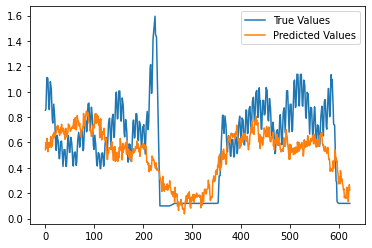

In [ ]:
'''
    TESTING
'''

train_loss = history.history['loss']
val_loss = history.history['val_loss']

print('End Train:', np.round(np.min(train_loss),3), ' End Val:', np.round(val_loss[-1],3), ' Min Val:', np.round(np.min(val_loss),3))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.show();

from sklearn.metrics import r2_score
preds = model.predict(hists_val).flatten()

RMSE_CNN = np.sqrt(np.mean((preds - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds - yields_val))
r2_CNN = r2_score(yields_val, preds)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)
plt.plot(yields_val, label='True Values');
plt.plot(preds, label='Predicted Values');
plt.legend(); plt.show();

#%%
#model.load_weights('Best Models/best_modelcnn0.hdf5')
model.load_weights('best_model_author.hdf5')
from sklearn.metrics import r2_score
preds_val = model.predict(hists_val).flatten()

RMSE_CNN = np.sqrt(np.mean((preds_val - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds_val - yields_val))
r2_CNN = r2_score(yields_val, preds_val)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)

#from scipy.stats import spearmanr
#print(spearmanr(preds_val, yields_val))
#m = 365
#num = np.mean(np.abs(yields_val - preds_val))
#den = np.sum(np.abs(yields_train[m + 1:] - yields_train[:-(m + 1)])) / (len(yields_train) - m)
#print('MASE:', num/den)

plt.plot(yields_val, label='True Values');
plt.plot(preds_val, label='Predicted Values');
plt.legend(); plt.show();
# %%


In [ ]:
np.save('author_sa_price_results1',preds_val)

In [ ]:

preds_val = np.load('author_sa_results.npy')

RMSE_CNN = np.sqrt(np.mean((preds_val - yields_val)**2))
MAE_CNN = np.mean(np.abs(preds_val - yields_val))
r2_CNN = r2_score(yields_val, preds_val)
agm_CNN = ((RMSE_CNN + MAE_CNN)/2)*(1-r2_CNN)
print ("MAE of CNN:",MAE_CNN)
print ("RMSE of CNN:", RMSE_CNN)
print ("R2 score of CNN:",r2_CNN)
print ("AGM score of CNN:",agm_CNN)

MAE of CNN: 63.77464700515949
RMSE of CNN: 91.95070995573757
R2 score of CNN: 0.8307223782556874
AGM score of CNN: 13.180409035812394
